<a href="https://colab.research.google.com/github/kotharisoumil/Info_Alchemists/blob/main/DTSC_1302_Group_20_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# Imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import io
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [33]:
url = "https://raw.githubusercontent.com/kotharisoumil/Info_Alchemists/refs/heads/main/adult.data"
column_headers = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
df = pd.read_csv(url, names=column_headers)
df.head(20)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [34]:
# Count occurrences of '?' (with or without surrounding whitespace)
question_mark_count = (df.map(lambda x: str(x).strip()) == '?').sum().sum()
print("Total '?' in dataset:", question_mark_count)

Total '?' in dataset: 4262


In [35]:
# Identify columns containing '?' (with or without surrounding whitespace)
columns_with_question_marks = df.map(lambda x: str(x).strip()).eq('?').sum()

# Filter columns with at least one '?'
columns_with_question_marks = columns_with_question_marks[columns_with_question_marks > 0]
print("Columns with '?':")
print(columns_with_question_marks)

Columns with '?':
workclass         1836
occupation        1843
native_country     583
dtype: int64


In [36]:
# Remove rows with '?' in the 'occupation' column (accounting for whitespace)
df['occupation'] = df['occupation'].str.strip().replace('?', pd.NA)
df_cleaned1 = df.dropna(subset=['occupation'])
df_cleaned2 = df_cleaned1.loc[:, ["age", "occupation", "sex", "education", "income"]]
df_cleaned2

,age,occupation,sex,education,income
0,39,Adm-clerical,Male,Bachelors,<=50K
1,50,Exec-managerial,Male,Bachelors,<=50K
2,38,Handlers-cleaners,Male,HS-grad,<=50K
3,53,Handlers-cleaners,Male,11th,<=50K
4,28,Prof-specialty,Female,Bachelors,<=50K
...,...,...,...,...,...
32556,27,Tech-support,Female,Assoc-acdm,<=50K
32557,40,Machine-op-inspct,Male,HS-grad,>50K
32558,58,Adm-clerical,Female,HS-grad,<=50K
32559,22,Adm-clerical,Male,HS-grad,<=50K


In [37]:
url_test = "https://raw.githubusercontent.com/kotharisoumil/Info_Alchemists/refs/heads/main/adult.test"
df_test = pd.read_csv(url_test, names=column_headers)

# Clean the 'occupation' column
df_test['occupation'] = df_test['occupation'].str.strip().replace('?', pd.NA)
df_test_cleaned = df_test.dropna(subset=['occupation'])
df_test_cleaned = df_test_cleaned.loc[:, ["age", "occupation", "sex", "education", "income"]]
df_test_cleaned

,age,occupation,sex,education,income
1,25,Machine-op-inspct,Male,11th,<=50K.
2,38,Farming-fishing,Male,HS-grad,<=50K.
3,28,Protective-serv,Male,Assoc-acdm,>50K.
4,44,Machine-op-inspct,Male,Some-college,>50K.
6,34,Other-service,Male,10th,<=50K.
...,...,...,...,...,...
16276,33,Prof-specialty,Male,Bachelors,<=50K.
16277,39,Prof-specialty,Female,Bachelors,<=50K.
16279,38,Prof-specialty,Male,Bachelors,<=50K.
16280,44,Adm-clerical,Male,Bachelors,<=50K.


In [38]:
# Combine the cleaned adult.data and adult.test dataframes
df_combined = pd.concat([df_cleaned2, df_test_cleaned], ignore_index=True)

# Convert 'occupation', 'sex', and 'education' to categorical variables
for col in ['occupation', 'sex', 'education']:
    if col in df_combined.columns:
        df_combined[col] = df_combined[col].astype('category')
    else:
        print(f"Column '{col}' not found in the DataFrame.")

# Create one-hot encoded features for 'occupation', 'sex', and 'education'
occupation_dummies = pd.get_dummies(df_combined['occupation'], prefix='occupation')
sex_dummies = pd.get_dummies(df_combined['sex'], prefix='sex')
education_dummies = pd.get_dummies(df_combined['education'], prefix='education')

# Combine the one-hot encoded features with the original DataFrame
df_combined = pd.concat([df_combined, occupation_dummies, sex_dummies, education_dummies], axis=1)

# Drop the original 'occupation', 'sex', and 'education' columns
df_combined = df_combined.drop(['occupation', 'sex', 'education'], axis=1)

# Convert the 'income' column to a binary label
df_combined['income'] = df_combined['income'].map({' <=50K.': 0, ' >50K.': 1}).fillna(0)

# Get the column names after one-hot encoding
X_cols = ['age'] + [col for col in df_combined.columns if col.startswith('occupation_') or col.startswith('sex_') or col.startswith('education_')]

# Split the data into training and testing sets
X = df_combined[X_cols]
y = df_combined['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy score: 0.9183230150972086
Classification report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8457
         1.0       0.00      0.00      0.00       750

    accuracy                           0.92      9207
   macro avg       0.46      0.50      0.48      9207
weighted avg       0.84      0.92      0.88      9207



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


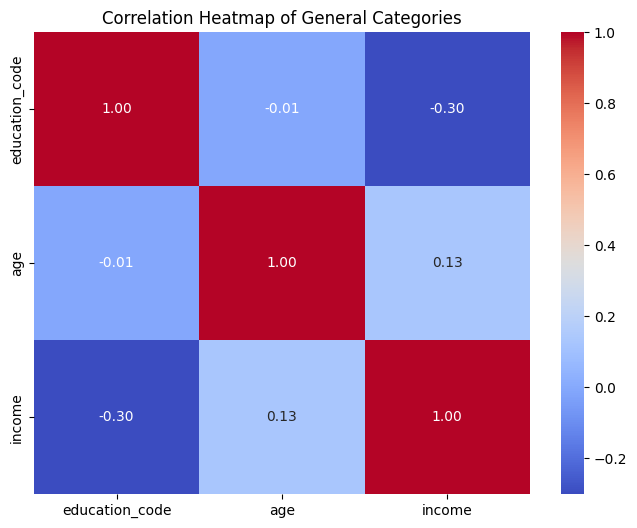

In [57]:
df_combined['education'] = df_cleaned2['education'].astype('category')

# Convert categorical columns to numeric codes
df_combined['education_code'] = df_combined['education'].cat.codes

# Create a correlation matrix with meaningful variables
correlation_columns = ['education_code', 'age', 'income']
correlation_matrix = df_combined[correlation_columns].corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of General Categories")
plt.show()

<ipython-input-30-3a3d56511ce1>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='viridis')


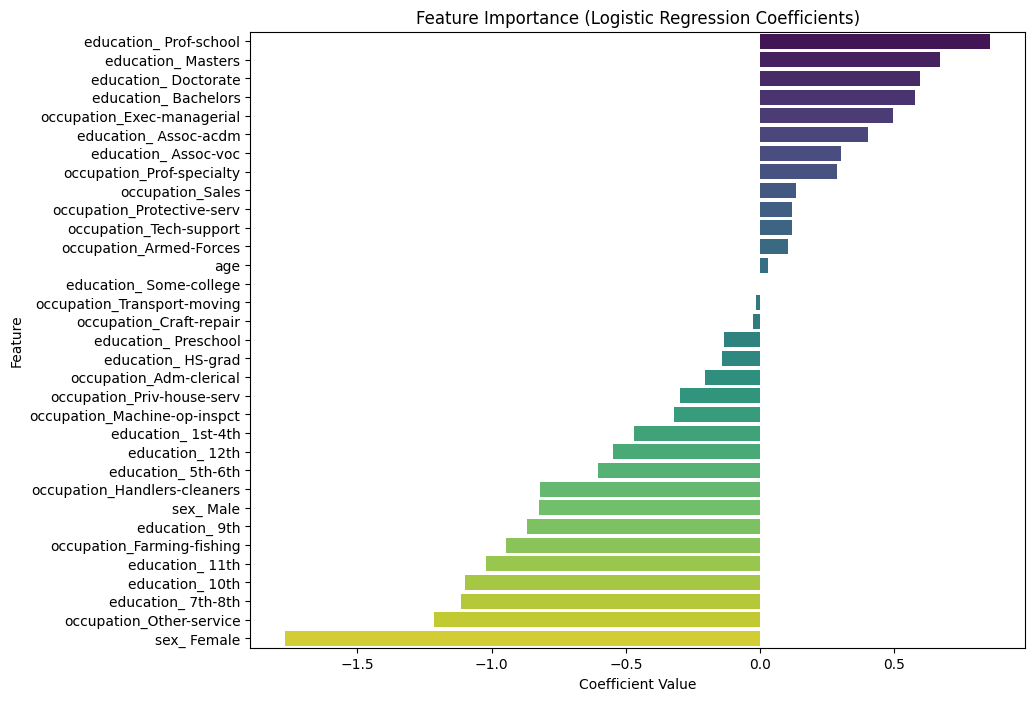

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='viridis')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

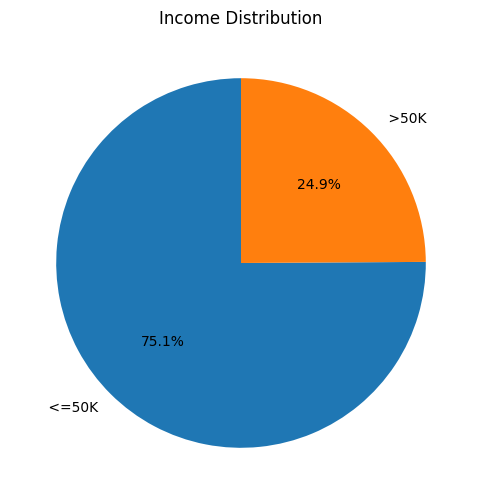

In [ ]:
# Assuming your data is in a pandas DataFrame called 'df_cleaned2'
income_counts = df_cleaned2['income'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(income_counts, labels=income_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Income Distribution')